<a href="https://colab.research.google.com/github/NirantK/Hinglish/blob/BERT/BERTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q keras-bert keras-rectified-adam

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp drive/My\ Drive/Hinglish/pretrained_bert500k.tar.gz .
!mv pretrained_bert500k.tar.gz pretrained_bert.tar.gz
!tar -xvf pretrained_bert.tar.gz

pretrained_bert/
pretrained_bert/bert_model.ckpt.data-00000-of-00001
pretrained_bert/bert_config.json
pretrained_bert/bert_model.ckpt.meta
pretrained_bert/vocab.txt
pretrained_bert/bert_model.ckpt.index


In [13]:
import pandas as pd
import re
def clean(df):
    df["clean_text"] = df["text"]
    df["clean_text"] = (
        (df["clean_text"])
            .apply(lambda text: re.sub(r"RT\s@\w+", "", text)) #Removes RTS
            .apply(lambda text: re.sub(r"@", "mention", text)) # Replaces @ with mention
            .apply(lambda text: re.sub(r"#", "hashtag", text)) # Replaces # with hastag
            .apply(lambda text: re.sub(r"http\S+", "", text)) # Removes URL
        )
    return df
# train and test json are available here https://drive.google.com/open?id=1Ij_THj01L-2Y1a8woOn9vXmHosW83e3R
# They are labeled twitter jsons with sentiments ["positive", "negative", "neutral"] attached to them
traindf= pd.read_json("drive/My Drive/Hinglish/interim/train.json")
testdf= pd.read_json("drive/My Drive/Hinglish/interim/test.json")

traindf = clean(traindf)
testdf = clean(testdf)
len(traindf), len(testdf)

(13600, 3400)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(traindf['sentiment'])
traindf['label'] = le.transform(traindf['sentiment'])
testdf['label'] = le.transform(testdf['sentiment'])

In [104]:
traindf["tokenized"] = traindf['clean_text'].apply(lambda x : tokenizer.encode(x, max_len=SEQ_LEN))
traindf.reset_index(inplace=True)
traindf

,index,uid,sentiment,text,clean_text,tokenized,label
0,237,1379,positive,RT @ cyrusgosh I CAN ’ T EVEN BELIEVE THAT I ’...,RT mention cyrusgosh I CAN ’ T EVEN BELIEVE TH...,"([101, 186, 10123, 33507, 171, 20728, 10251, 1...",2
1,14202,35969,positive,@ gArmygirl @ peaceforchange # PakistanZindaba...,mention gArmygirl mention peaceforchange hasht...,"([101, 33507, 47243, 14996, 92507, 33507, 2810...",2
2,1136,24314,neutral,@ BabarAbidi @ uzair251 @ zartajgulwazir Yar m...,mention BabarAbidi mention uzair251 mention za...,"([101, 33507, 15688, 43221, 78489, 10116, 3350...",1
3,16740,12400,negative,RT @ aleeshadontcare Baap ki izzat beti k hath...,RT mention aleeshadontcare Baap ki izzat beti ...,"([101, 186, 10123, 33507, 11372, 38806, 11272,...",0
4,14213,36030,positive,@ sarbjee52789190 @ BabyK34446271 Jhoot gali g...,mention sarbjee52789190 mention BabyK34446271 ...,"([101, 33507, 10148, 50579, 76083, 92161, 1130...",2
...,...,...,...,...,...,...,...
13595,5061,13111,negative,RT @ sza Holding ur tongue so exhausting !!! F...,RT mention sza Holding ur tongue so exhausting...,"([101, 186, 10123, 33507, 61048, 10113, 29008,...",0
13596,944,4654,positive,@ AbbassFr Budget tu pass ho jaye ga . Har baa...,mention AbbassFr Budget tu pass ho jaye ga . H...,"([101, 33507, 11357, 21322, 10107, 71843, 2529...",2
13597,12931,30610,positive,@ narendramodi177 Congratulations all of you ....,mention narendramodi177 Congratulations all of...,"([101, 33507, 90086, 96086, 11033, 10703, 3426...",2
13598,10098,23584,positive,RT @ AshVerma111 So sweet .. thank you soo muc...,RT mention AshVerma111 So sweet .. thank you s...,"([101, 186, 10123, 33507, 83244, 12563, 10369,...",2


In [105]:
testdf["tokenized"] = testdf['clean_text'].apply(lambda x : tokenizer.encode(x, max_len=SEQ_LEN))
testdf.reset_index(inplace=True)
testdf

,index,uid,sentiment,text,clean_text,label,tokenized
0,7135,16677,positive,@ asadowaisi @ aimim _ national @ narendramodi...,mention asadowaisi mention aimim _ national me...,2,"([101, 33507, 81387, 53418, 14553, 33507, 5604..."
1,7291,16986,positive,Hamare nabinji odissa c m congratulations apko...,Hamare nabinji odissa c m congratulations apko...,2,"([101, 96474, 10112, 10132, 16473, 10775, 1031..."
2,4608,12168,negative,@ Mahende67015515 @ RahulGandhi maa ko pairo s...,mention Mahende67015515 mention RahulGandhi ma...,0,"([101, 33507, 29325, 13201, 11211, 48205, 3746..."
3,3021,6598,neutral,@ alehsfeemi @ MrDannyxX007 Ab kia kia es me s...,mention alehsfeemi mention MrDannyxX007 Ab kia...,1,"([101, 33507, 11372, 22394, 14601, 32080, 3350..."
4,11178,26490,neutral,@_ pallavighosh Food packet choro gaadi pe kap...,mention_ pallavighosh Food packet choro gaadi ...,1,"([101, 33507, 168, 29330, 25768, 26009, 10310,..."
...,...,...,...,...,...,...,...
3395,10197,23883,neutral,@ ZeeNewsHindi Neetesh kumar palti maar Baba h...,mention ZeeNewsHindi Neetesh kumar palti maar ...,1,"([101, 33507, 68843, 72078, 102482, 10554, 348..."
3396,10777,25574,neutral,@ ifOnlyKewal Jiske naam pe filme chlti thi na...,mention ifOnlyKewal Jiske naam pe filme chlti ...,1,"([101, 33507, 12277, 10263, 10454, 10550, 3787..."
3397,4726,12528,negative,@ ZarmanB @ WeUttarPradesh @ bareillypolice @ ...,mention ZarmanB mention WeUttarPradesh mention...,0,"([101, 33507, 10339, 26226, 10457, 33507, 1195..."
3398,7599,17592,negative,@ Nidhi @ JhaSanjay NDTV wale kutte ki maut au...,mention Nidhi mention JhaSanjay NDTV wale kutt...,0,"([101, 33507, 92181, 11924, 33507, 178, 68398,..."


In [96]:
import keras as keras
import keras.backend as K
from keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

Using TensorFlow backend.


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 128
EPOCHS = 5
LR = 1e-4

pretrained_path = 'pretrained_bert'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'clean_text'
LABEL_COLUMN = 'label'

In [0]:
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)


In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    np.random.shuffle(items)
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

In [0]:
def load_data(data_df):
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

In [147]:
train_x, train_y = load_data(traindf)

100%|██████████| 13600/13600 [00:05<00:00, 2435.35it/s]


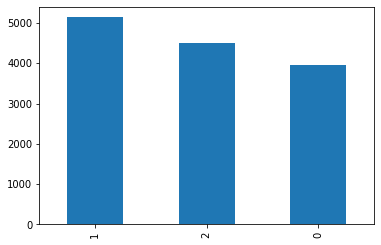

In [148]:
pd.Series(train_y).value_counts().plot(kind = 'bar')

In [0]:
model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
    )

In [155]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
___________________________________________________________________________________________

In [0]:
inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=3, activation='softmax')(dense)
model = keras.models.Model(inputs, outputs)
model.compile(
        RAdam(lr=LR),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

In [0]:
# @title Initialize Variables
import tensorflow as tf
import tensorflow.keras.backend as K

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

In [0]:
# @title Fit

model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Train on 13600 samples
Epoch 1/5
 7168/13600 [==============>...............] - ETA: 6:39 - loss: 0.8855 - sparse_categorical_accuracy: 0.5739

In [0]:
test_x, test_y = load_data(testdf)

In [0]:
predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

In [0]:
# @title Accuracy

print(np.sum(test_y == predicts) / test_y.shape[0])

In [0]:
import pandas as pd

validdf = pd.read_json('valid.json')
validdf = clean(validdf)
validdf['label'] = 0 #because I didn't want to write the entire load_data function
valid_x, valid_y = load_data(validdf)

In [0]:
predicts = model.predict(valid_x, verbose=True).argmax(axis=-1)
output = le.inverse_transform(predicts)

In [0]:
with open('output.csv', 'w') as f:
    for i in range(len(output.tolist())):
        f.write(f"{validdf.loc[i]['uid']},{output[i]}\n")

In [0]:
!cp output.csv drive/My\ Drive/Hinglish/